# Task overview

You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

# Data overview

Each sample in the train and test set has the following information:

- The text of a tweet
- A keyword from that tweet (although this may be blank!)
- The location the tweet was sent from (may also be blank)

**Importing libraries**

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer

**Loading data**

In [7]:
sns.set_style("whitegrid")

try:
    train_df = pd.read_csv("D:/disaster_tweets/disaster_tweets/data/raw/train.csv")
    test_df = pd.read_csv("D:/disaster_tweets/disaster_tweets/data/raw/test.csv")
    print("Data loaded successfully")
except FileNotFoundError:
    print("File not found. Please check the path.")

Data loaded successfully


In [8]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


**Basic EDA**

##################### Shape #####################
(7613, 5)

##################### Types #####################
id          int64
keyword       str
location      str
text          str
target      int64
dtype: object

##################### Missing Values #####################
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

##################### Duplicates #####################
0

##################### Quantiles #####################
         count         mean         std  min   0%     5%     50%      95%  \
id      7613.0  5441.934848  3137.11609  1.0  1.0  548.4  5408.0  10356.2   
target  7613.0     0.429660     0.49506  0.0  0.0    0.0     0.0      1.0   

             99%     100%      max  
id      10774.88  10873.0  10873.0  
target      1.00      1.0      1.0  


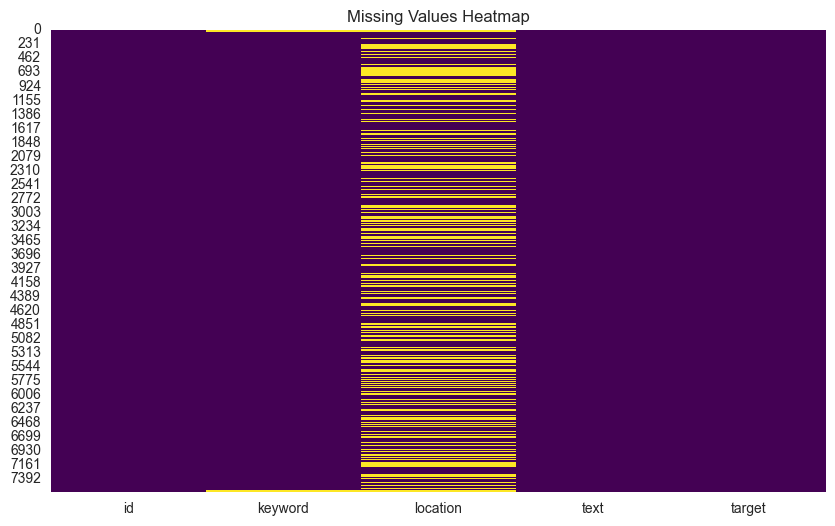

In [9]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("\n##################### Types #####################")
    print(dataframe.dtypes)
    print("\n##################### Missing Values #####################")
    print(dataframe.isnull().sum())
    print("\n##################### Duplicates #####################")
    print(dataframe.duplicated().sum())
    print("\n##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(train_df)

plt.figure(figsize=(10, 6))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

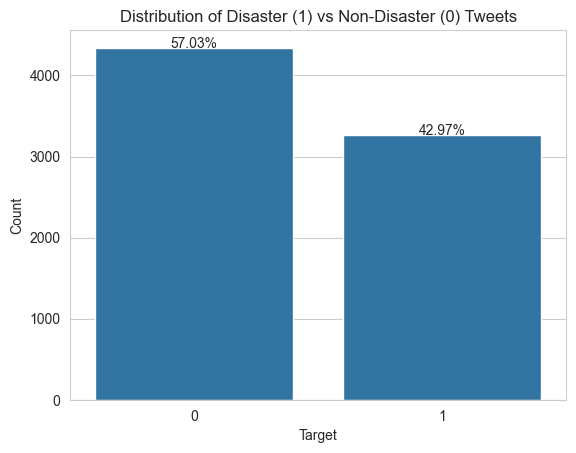

In [15]:
total = len(train_df)
ax = sns.countplot(x='target', data=train_df)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 3,
            '{:1.2f}%'.format((height / total) * 100),
            ha="center")

plt.title('Distribution of Disaster (1) vs Non-Disaster (0) Tweets')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

In [12]:
duplicate_texts = train_df[train_df.duplicated(subset=['text'], keep=False)]
print(f"Количество дубликатов по тексту: {duplicate_texts.shape[0]}")

Количество дубликатов по тексту: 179


In [13]:
inconsistent_labels = duplicate_texts.groupby('text')['target'].nunique()
inconsistent_labels = inconsistent_labels[inconsistent_labels > 1]

In [14]:
print(f"Found {len(inconsistent_labels)} texts with insonsistent labeling")
print("Inconsistency examples:")
print(train_df[train_df['text'].isin(inconsistent_labels.index[:3])].sort_values('text'))

Found 18 texts with insonsistent labeling
Inconsistency examples:
        id    keyword                    location  \
4290  6094   hellfire    Jubail IC, Saudi Arabia.   
4299  6105   hellfire  ?????? ??? ?????? ????????   
4312  6123   hellfire          ?????? ???? ??????   
4221  5996  hazardous                         NaN   
4239  6023  hazardous           Mysore, Karnataka   
4244  6031  hazardous            New Delhi, Delhi   
2830  4068  displaced    Pedophile hunting ground   
2831  4072  displaced    Pedophile hunting ground   
2832  4076  displaced    Pedophile hunting ground   
2833  4077  displaced    Pedophile hunting ground   

                                                   text  target  
4290  #Allah describes piling up #wealth thinking it...       0  
4299  #Allah describes piling up #wealth thinking it...       0  
4312  #Allah describes piling up #wealth thinking it...       1  
4221  #foodscare #offers2go #NestleIndia slips into ...       1  
4239  #foodscare #of

**Tweet analysis**

In [17]:
df_eda = train_df.copy()

df_eda['char_count'] = df_eda['text'].str.len()

df_eda['word_count'] = df_eda['text'].apply(lambda x: len(str(x).split()))

df_eda['avg_word_len'] = df_eda['char_count'] / (df_eda['word_count'] + 1)

df_eda['url_count'] = df_eda['text'].apply(lambda x: len([w for w in str(x).split() if 'http' in w]))

df_eda['hashtag_count'] = df_eda['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

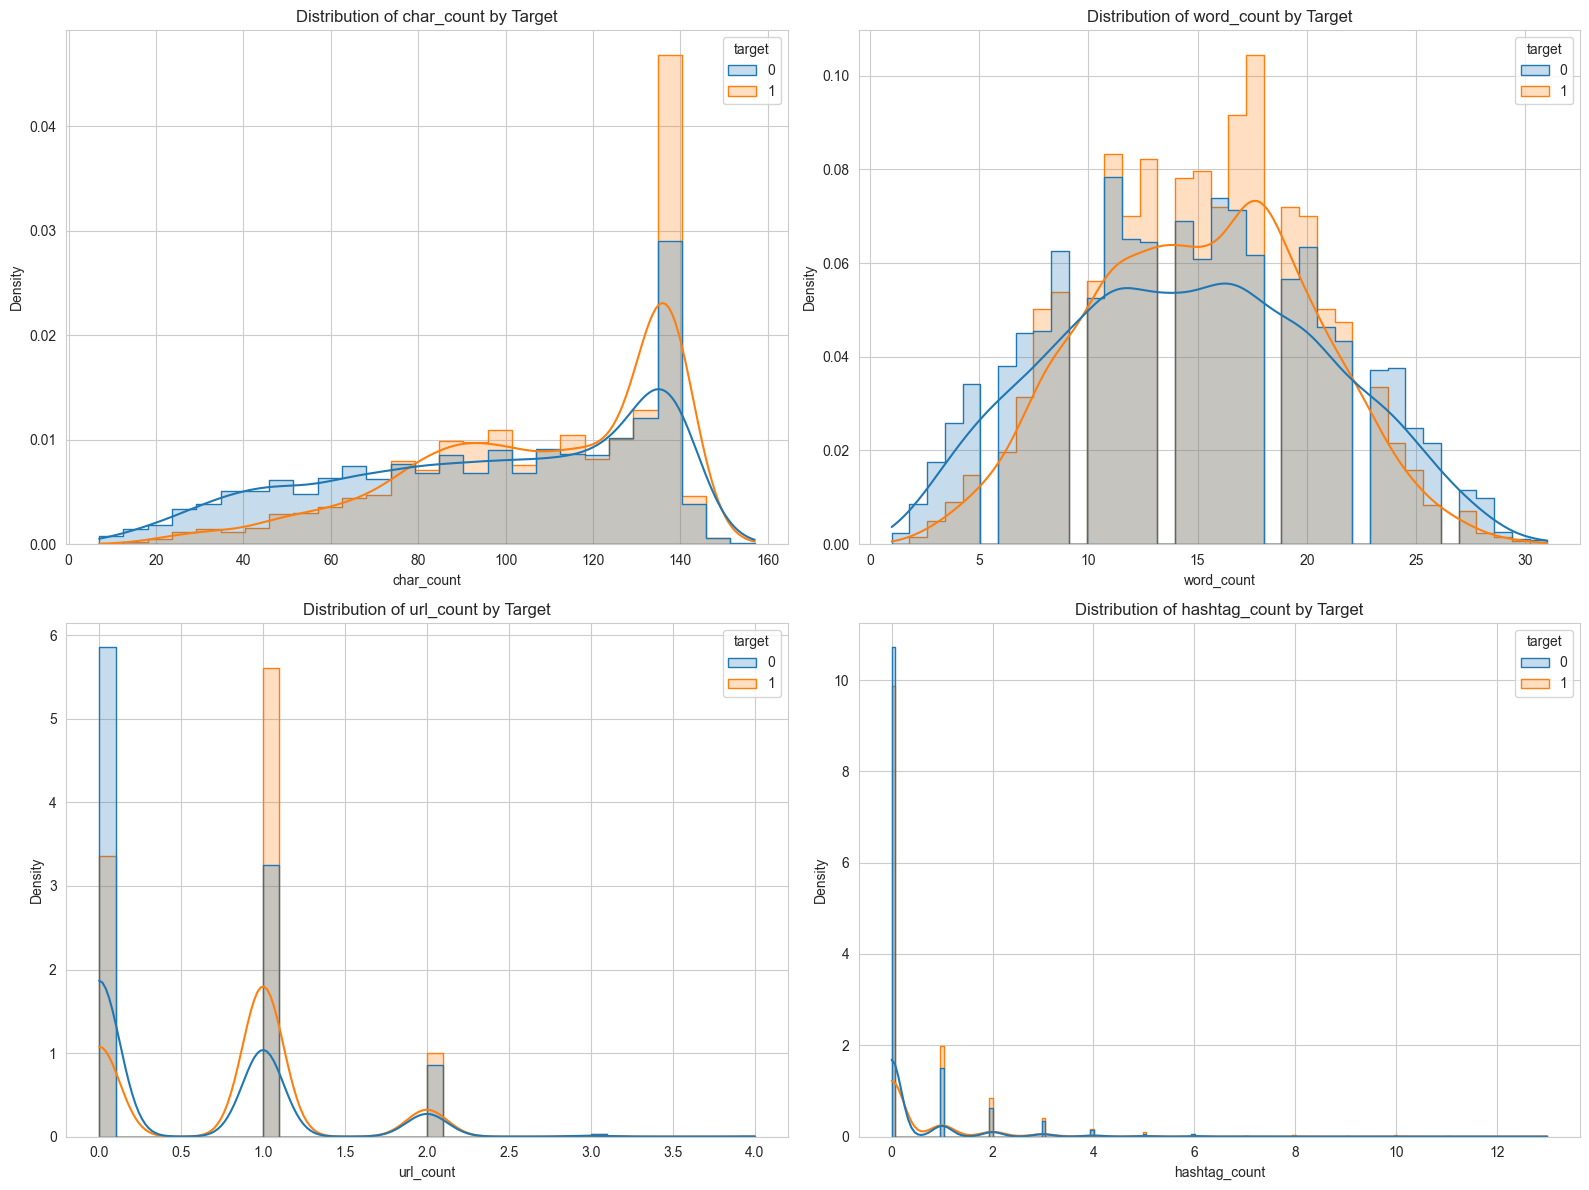

In [18]:
meta_features = ['char_count', 'word_count', 'url_count', 'hashtag_count']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
axes = axes.flatten()

for i, feature in enumerate(meta_features):
    sns.histplot(
        data=df_eda, 
        x=feature, 
        hue='target', 
        kde=True, 
        element="step", 
        stat="density", 
        common_norm=False, 
        ax=axes[i]
    )
    axes[i].set_title(f'Distribution of {feature} by Target')

plt.tight_layout()
plt.show()

C:\Users\37529\AppData\Local\Temp\ipykernel_2940\1568990192.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=df_plot, palette='viridis')


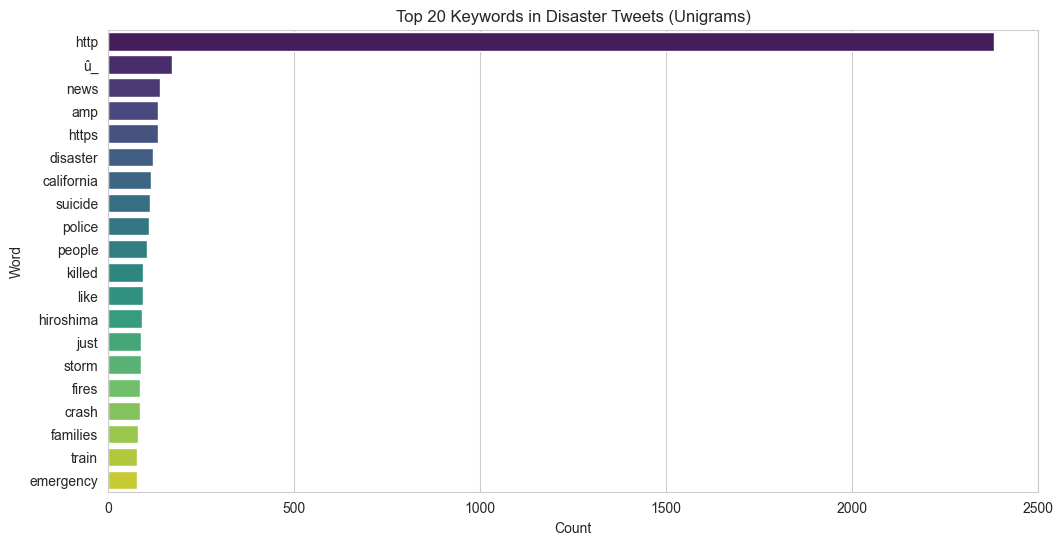

C:\Users\37529\AppData\Local\Temp\ipykernel_2940\1568990192.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=df_plot, palette='viridis')


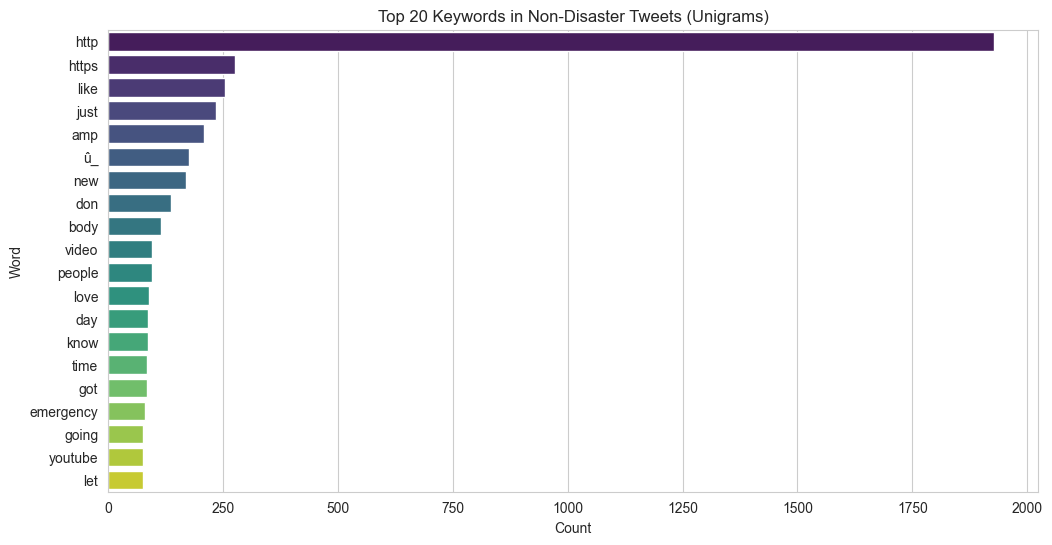

C:\Users\37529\AppData\Local\Temp\ipykernel_2940\1568990192.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=df_plot, palette='viridis')


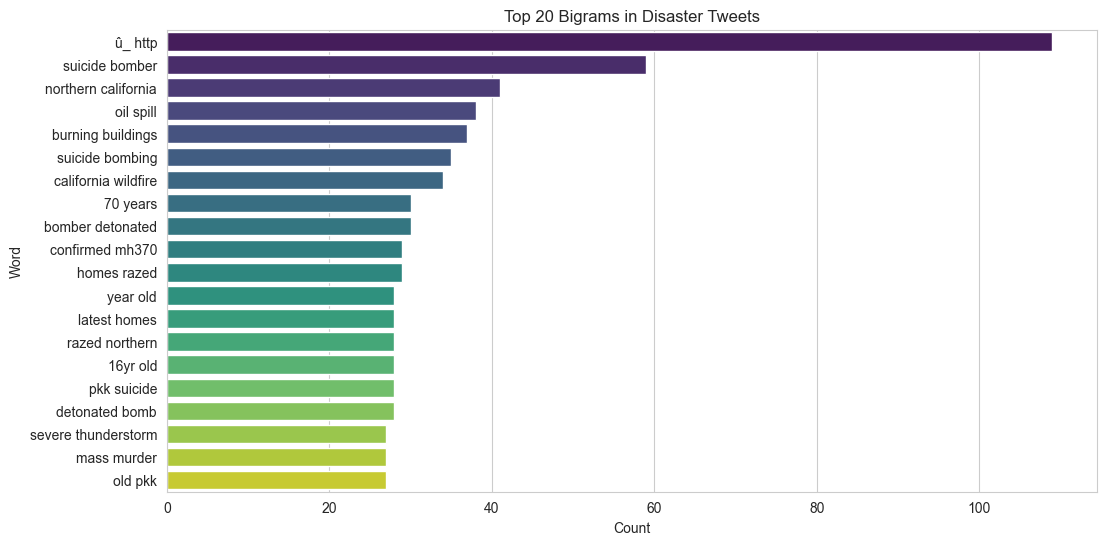

In [20]:
def plot_top_ngrams(corpus, title, n_gram=1, top_k=20):
    vec = CountVectorizer(stop_words='english', ngram_range=(n_gram, n_gram)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_k]
    
    df_plot = pd.DataFrame(words_freq, columns=['Word', 'Count'])
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Count', y='Word', data=df_plot, palette='viridis')
    plt.title(title)
    plt.show()

disaster_text = df_eda[df_eda['target'] == 1]['text']
non_disaster_text = df_eda[df_eda['target'] == 0]['text']

plot_top_ngrams(disaster_text, 'Top 20 Keywords in Disaster Tweets (Unigrams)', n_gram=1)
plot_top_ngrams(non_disaster_text, 'Top 20 Keywords in Non-Disaster Tweets (Unigrams)', n_gram=1)

plot_top_ngrams(disaster_text, 'Top 20 Bigrams in Disaster Tweets', n_gram=2)